In [1]:
print("Welcome to my EMR Notebook!")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9,application_1632135889412_0010,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Welcome to my EMR Notebook!

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
9,application_1632135889412_0010,pyspark,idle,Link,Link,✔


In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
jmespath                   0.10.0   
joblib                     1.0.1    
lxml                       4.6.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
setuptools                 28.8.0   
six                        1.13.0   
tqdm                       4.59.0   
wheel                      0.29.0   
windmill                   1.6

In [4]:
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository
sc.install_pypi_package("time") #Install pandas version 0.25.1 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/7c/ec/3d77b10ac3d30590f5431fd2dc59c58d20c020af107b47f8974896afc5c9/matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d6/28/827b9cac687e086110eb133ab7e4f36ab4b35a1e1654c6329840ce045354/Pillow-8.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/09/6b/6e567cb2e86d4e5939a9233f8734e26021b6a9c1bc4b1edccba236a84cc2/kiwisolver-1.3.2-cp37-cp37m-manylinu

In [5]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import time

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
entry_green_taxi_df_2019_5 = spark.read.csv("s3://nyc-tlc/trip data/green_tripdata_2019-05.csv", header=True, inferSchema=True)
entry_yellow_taxi_df_2019_5 = spark.read.csv("s3://nyc-tlc/trip data/yellow_tripdata_2019-05.csv", header=True, inferSchema=True)
entry_green_taxi_df_2020_5 = spark.read.csv("s3://nyc-tlc/trip data/green_tripdata_2020-05.csv", header=True, inferSchema=True)
entry_yellow_taxi_df_2020_5 = spark.read.csv("s3://nyc-tlc/trip data/yellow_tripdata_2020-05.csv", header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
# we need to extract passenger_count and payment_type
start_time = time.time()

green_2019  = entry_green_taxi_df_2019_5.select(["passenger_count", "payment_type"])
yellow_2019  = entry_yellow_taxi_df_2019_5.select(["passenger_count", "payment_type"])
green_2020  = entry_green_taxi_df_2020_5.select(["passenger_count", "payment_type"])
yellow_2020  = entry_yellow_taxi_df_2020_5.select(["passenger_count", "payment_type"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
data_2020 = green_2020.union(yellow_2020)
data_2019 = green_2019.union(yellow_2019)

data = data_2020.union(data_2019) #whole data

#data = data_2019 #only 2019

#data = data_2020 #only 2020

data_1_pass = data.filter("passenger_count == 1")
data_2_pass = data.filter("passenger_count == 2")
data_3_pass = data.filter("passenger_count == 3")
data_4_pass = data.filter("passenger_count == 4")
data_5andMore_pass = data.filter("passenger_count > 4")
our_frames = [data_1_pass,data_2_pass,data_3_pass,data_4_pass,data_5andMore_pass]


labels = ["Card","Cash","No charge","Dispute","Unknown"]
x = np.arange(len(labels))
width = 0.7
fig, ax = plt.subplots()

percentages_for_each_nr_of_pass = []
for passenger_count in our_frames:
    data_grouped_by_payment_type = passenger_count.groupBy("payment_type").count().sort("payment_type")
    total_num_of_payments = data_grouped_by_payment_type.agg(F.sum("count")).collect()[0][0]

    data_with_percentage_column = data_grouped_by_payment_type.withColumn('Percentage', (100*data_grouped_by_payment_type['count'] / float(total_num_of_payments)))
    only_percentage_data = data_with_percentage_column.select(["Percentage"])
    zmienna = only_percentage_data.select('Percentage').rdd.flatMap(lambda x: x).collect()
    if len(zmienna)<5:
        zmienna.append(0)
    percentages_for_each_nr_of_pass.append(zmienna)
    
print("--- %s seconds ---" % (time.time() - start_time))

rects1 = ax.bar(x-width/5, percentages_for_each_nr_of_pass[0], width/5, label="1 passenger")
rects2 = ax.bar(x-2*width/5, percentages_for_each_nr_of_pass[1], width/5, label="2 passengers")
rects3 = ax.bar(x, percentages_for_each_nr_of_pass[2], width/5, label="3 passengers")
rects4 = ax.bar(x+width/5, percentages_for_each_nr_of_pass[3], width/5, label="4 passengers")
rects5 = ax.bar(x+2*width/5, percentages_for_each_nr_of_pass[4], width/5, label="5 or more")

ax.set_ylabel("Percentage of transactions")
ax.set_title("Percentages of transactions by number of passengers in may 2020")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 60.884305238723755 seconds ---

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

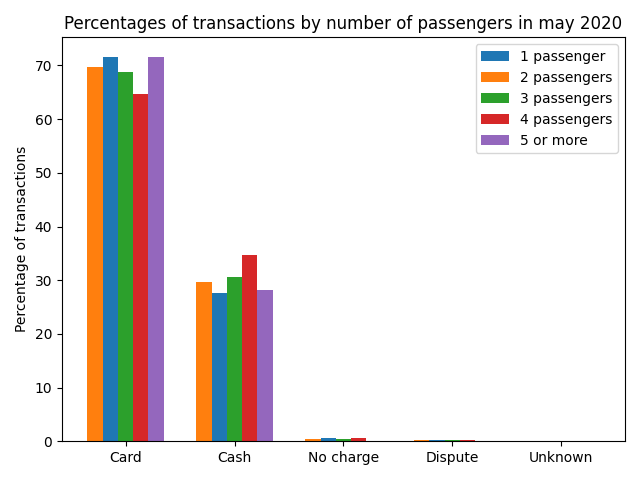

In [38]:
%matplot plt

In [39]:
print(percentages_for_each_nr_of_pass)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[71.64988701700622, 27.575517155444654, 0.5647665253891709, 0.20954987903598324, 0.0002794231239749756], [69.64115321130713, 29.69140783248906, 0.4773519397078469, 0.18991961269456506, 0.00016740380140552232], [68.76930669542489, 30.600693365503542, 0.43838003497291733, 0.1913152619617735, 0.0003046421368818049], [64.63307346651507, 34.60559796437659, 0.5637215093931027, 0.19760705971522927, 0], [71.63264842688507, 28.167140386267555, 0.14098046710897316, 0.05923071973840081, 0]]

In [40]:
data_card_2019 = data_2019.filter("payment_type == 1")
data_cash_2019= data_2019.filter("payment_type == 2")
data_other_2019 = data_2019.filter("payment_type > 2")



data_card_2020 = data_2020.filter("payment_type == 1")
data_cash_2020 = data_2020.filter("payment_type == 2")
data_other_2020 = data_2020.filter("payment_type > 2")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
# Some data
overall_card_2019 = data_card_2019.count()
overall_cash_2019 = data_cash_2019.count()
overall_other_2019 = data_other_2019.count()

overall_card_2020 = data_card_2020.count()
overall_cash_2020 = data_cash_2020.count()
overall_other_2020 = data_other_2020.count()


labels = 'Card', 'Cash', 'Other'
fracs_2019 = [overall_card_2019, overall_cash_2019, overall_other_2019]
fracs_2020 = [overall_card_2020, overall_cash_2020, overall_other_2020]
# Make figure and axes
fig, axs = plt.subplots(1, 2)

# A standard pie plot
axs[0].pie(fracs_2019, labels=labels, autopct='%1.1f%%')

# Shift the second slice using explode
axs[1].pie(fracs_2020, labels=labels, autopct='%1.1f%%')




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

([<matplotlib.patches.Wedge object at 0x7f8a6af89ad0>, <matplotlib.patches.Wedge object at 0x7f8a6af15290>, <matplotlib.patches.Wedge object at 0x7f8a6af15a90>], [Text(-0.3142082219716108, 1.0541694328927582, 'Card'), Text(0.25171220052291327, -1.0708132274621531, 'Cash'), Text(1.0980987453308084, -0.06464631082207598, 'Other')], [Text(-0.17138630289360587, 0.5750015088505953, '59.2%'), Text(0.13729756392158904, -0.5840799422520835, '38.9%'), Text(0.5989629519986227, -0.035261624084768704, '1.9%')])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

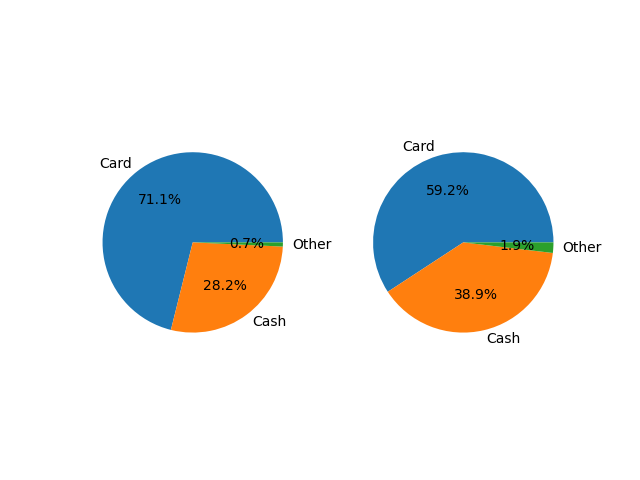

In [43]:
%matplot plt

In [48]:
print(data_2019.count())
print(data_2020.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8070148
405731